# Economotrics Project (BGD708)

#### Authors: 
Alban Pereira (alban.pereira@telecom-paris.fr)

Laurent Gayraud (laurent.gayraud@telecom-paris.fr)

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import GLS
from statsmodels.stats.stattools import durbin_watson
from scipy.linalg import toeplitz

## <span style="color:red"> PARTIE 1 - CROSS-SECTION DATA</span>
Cette partie utilise le jeu de données HPRICE2.RAW décrit dans HPRICE2.DES.

#### <span style="color:green"> Introduction, imports.</span>

In [2]:
# Importation des données
df = pd.read_csv('data/HPRICE2.raw', delim_whitespace=True, header=None)

# Insertion des noms de colonnes
columns = [
    "price", "crime", "nox", "rooms", "dist", "radial", "proptax", "stratio",
    "lowstat", "lprice", "lnox", "lproptax"
]
df.columns = columns

df.head()

,price,crime,nox,rooms,dist,radial,proptax,stratio,lowstat,lprice,lnox,lproptax
0,24000,0.006,5.38,6.57,4.09,1,29.6,15.3,4.98,10.085810,1.682688,5.690360
1,21599,0.027,4.69,6.42,4.97,2,24.2,17.8,9.14,9.980402,1.545433,5.488938
2,34700,0.027,4.69,7.18,4.97,2,24.2,17.8,4.03,10.454500,1.545433,5.488938
3,33400,0.032,4.58,7.00,6.06,3,22.2,18.7,2.94,10.416310,1.521699,5.402678
4,36199,0.069,4.58,7.15,6.06,3,22.2,18.7,5.33,10.496790,1.521699,5.402678


In [3]:
df.shape

(506, 12)

Le fichier HPRICE2.DES décrit un ensemble de données contenant 506 observations avec les variables suivantes :
1. price : prix médian des logements, en dollars
2. crime : crimes commis par habitant
3. nox : oxyde nitreux, parties pour 100 millions
4. rooms : nombre moyen de chambres par maison
5. dist : distance pondérée jusqu'à 5 centres d'emploi
6. radial : indice d'accessibilité aux autoroutes radiales
7. proptax : taxe foncière par 1000 dollars
8. stratio : ratio moyen élève-enseignant
9. lowstat : % de personnes de 'statut inférieur'
10. lprice : logarithme du prix
11. lnox : logarithme de nox
12. lproptax : logarithme de la taxe foncière

#### <span style="color:green"> Q1. State the fundamental hypothesis under which the Ordinary Least Squares (OLS) estimators are unbiased.</span>

L'hypothèse fondamentale sous laquelle les estimateurs des moindres carrés ordinaires (OLS) sont non biaisés est que **la variable non observée a une moyenne nulle** , **la moyenne conditionnelle est égale à la moyenne inconditionnelle**, et qu'**il n'y a pas de corrélation entre les variables explicatives X et le terme d'erreur u**.  
  
Nous avons donc $E(u∣X) = E(u)= 0$.  
  
En d'autres termes, ce que l'on observe est indépendant de ce que l'on n'observe pas.

#### <span style="color:green"> Q2. Show that under this assumption the OLS estimators are indeed unbiased.</span>

Sous l'hypothèse que $E(u|X) = 0$, où $u$ est le terme d'erreur et $X$ représente les variables indépendantes, les estimateurs des moindres carrés ordinaires (OLS) $\hat{\beta}$ sont non biaisés. Cela est montré comme suit :

Étant donné un modèle linéaire $Y = X\beta + u$,

1. L'estimateur OLS $\hat{\beta}$ est donné par $\hat{\beta} = (X'X)^{-1}X'Y$  
Sous réserve que le produit $(X'X)$ soit inversible ce qui ce traduit par une absence de colinéarité parfaite entre X' et X ce qui est une hypothèse de notre modèle.   
L'inversibilité implique également que le nombre d'observations doit être suffisant pour fournir une variation suffisante dans les données, ce qui aide à éviter une situation où X pourrait être singulière. Etant donnée la forme des données (12 colonnes pour plus de 500 lignes), cette hypothèse est aussi vérifiée.
  
2. En substituant $Y = X\beta + u$ dans l'équation de l'estimateur, on obtient $\hat{\beta} = (X'X)^{-1}X'(X\beta + u)$.
3. En simplifiant $( (X'X)^{-1}(X'X) = I )$, on obtient : $\hat{\beta} = \beta + (X'X)^{-1}X'u$.

En prenant l'espérance :

4. $E(\hat{\beta}) = E(\beta + (X'X)^{-1}X'u) = \beta + (X'X)^{-1}X'E(u)$.

D'après l'hypothèse fondamentale $E(u|X) = E(u) = 0$, donc :

5. $E(\hat{\beta}) = \beta$.

Par conséquent, sous l'hypothèse fondamentale, les estimateurs OLS $\hat{\beta}$ sont non biaisés, ce qui signifie que $E(\hat{\beta}) = \beta$.


#### <span style="color:green"> Q3. Explain the sample selection bias with an example from the course.</span>

Le biais de sélection d'échantillon se produit lorsque **l'échantillon ne représente pas précisément la population, conduisant à des estimations biaisées**.

Un exemple tiré du cours est l'étude de l'effet de l'engrais sur le rendement des cultures. Si davantage d'engrais est systématiquement appliqué à des terres intrinsèquement plus fertiles, l'analyse peut attribuer à tort le rendement supérieur à l'engrais, en négligeant la fertilité intrinsèque de la terre. Cela se produit parce que la sélection des parcelles pour la fertilisation est influencée par un facteur non observé (la fertilité de la terre) qui affecte également le résultat (le rendement), provoquant une surestimation de l'effet de l'engrais.  
  
Corriger ce biais nécessite des techniques pour tenir compte de telles variables non observées.

#### <span style="color:green"> Q4. Explain the omitted variable bias with an example from the course.</span>

Le biais de variable omise se produit lorsqu'**une variable pertinente est exclue d'un modèle, causant des estimations biaisées des effets d'autres variables**.
  
Un exemple du cours relatif à l'effet de l'éducation sur les salaires pourrait bien illustrer ce concept. Si nous examinons comment l'éducation affecte les salaires sans tenir compte de l'expérience professionnelle, nous pourrions surestimer l'impact de l'éducation. Cela est dû au fait que l'éducation et l'expérience professionnelle influencent toutes deux les salaires, mais omettre l'expérience professionnelle signifie qu'une partie de l'effet observé de l'éducation sur les salaires peut en réalité être due à l'expérience professionnelle, qui est corrélée avec l'éducation.

#### <span style="color:green"> Q5. Explain the problem of multicollinearity. Is it a problem in this dataset?</span>

La multicollinéarité dans un modèle de régression survient lorsque plusieurs variables explicatives sont linéairement dépendantes, ou presque.  
Cette interdépendance peut entraîner une matrice  singulière ou presque singulière, dont le déterminant est proche de zéro. Or l'inversibilité de $(X'X)$ est cruciale car l'estimateur des moindres carrés est défini en dépend. Sans inverse, nous ne pouvons pas calculer cet estimateur avec précision.

Pour pallier la multicollinéarité, on peut augmenter le nombre d'observations pour renforcer la robustesse de la matrice ou diminuer le nombre de variables explicatives en les retirant.

In [4]:
# Calcul de la matrice de corrélation
correlation_matrix = df.drop(['price', 'lprice'], axis=1).corr()
correlation_matrix

,crime,nox,rooms,dist,radial,proptax,stratio,lowstat,lnox,lproptax
crime,1.000000,0.421152,-0.218816,-0.379909,0.625442,0.582819,0.288691,0.447033,0.429639,0.551393
nox,0.421152,1.000000,-0.302828,-0.770222,0.610328,0.666981,0.186863,0.585613,0.993943,0.659206
rooms,-0.218816,-0.302828,1.000000,0.205410,-0.209773,-0.292120,-0.354008,-0.609605,-0.304988,-0.299269
dist,-0.379909,-0.770222,0.205410,1.000000,-0.495065,-0.534379,-0.229269,-0.495602,-0.808795,-0.513897
radial,0.625442,0.610328,-0.209773,-0.495065,1.000000,0.910228,0.464244,0.476038,0.624171,0.863531
proptax,0.582819,0.666981,-0.292120,-0.534379,0.910228,1.000000,0.454238,0.527624,0.677314,0.988586
stratio,0.288691,0.186863,-0.354008,-0.229269,0.464244,0.454238,1.000000,0.365402,0.227910,0.422231
lowstat,0.447033,0.585613,-0.609605,-0.495602,0.476038,0.527624,0.365402,1.000000,0.596220,0.510948
lnox,0.429639,0.993943,-0.304988,-0.808795,0.624171,0.677314,0.227910,0.596220,1.000000,0.667252
lproptax,0.551393,0.659206,-0.299269,-0.513897,0.863531,0.988586,0.422231,0.510948,0.667252,1.000000


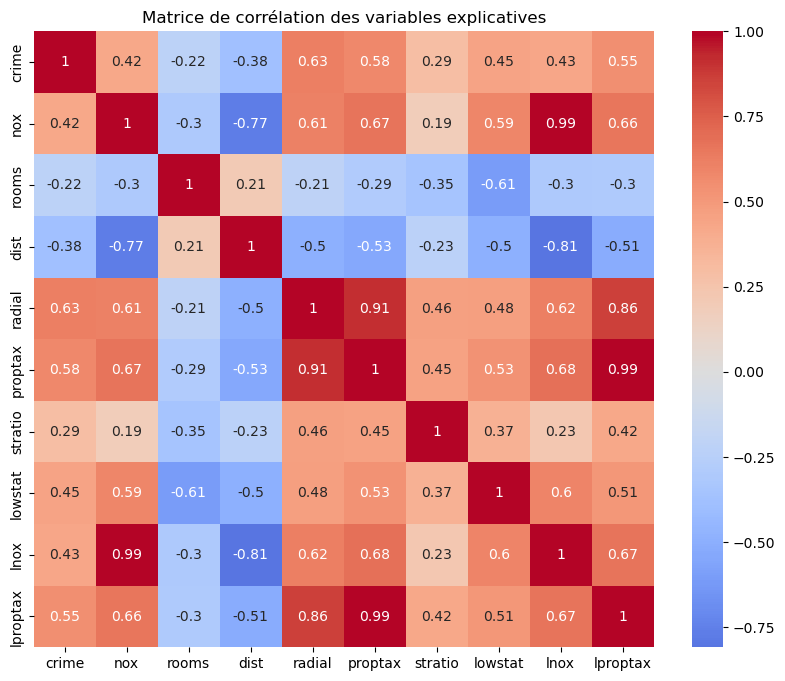

In [5]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des variables explicatives')
plt.show()

La matrice de corrélation et la carte thermique révèlent plusieurs paires de variables explicatives avec des coefficients de corrélation élevés, indiquant des problèmes potentiels de multicollinéarité dans l'ensemble de données. Par exemple :

- _nox_ et _lnox_ présentent une corrélation très élevée proche de 1, ce qui est attendu puisque _lnox_ est le logarithme de _nox_.
- _proptax_ et _lproptax_ affichent également une corrélation très élevée pour la même raison.
- _radial_ et _proptax_ ont un coefficient de corrélation de 0,91, suggérant une forte relation linéaire.
- _dist_ et _nox_ ont une corrélation négative de -0,77, indiquant qu'à mesure que la distance par rapport aux centres d'emploi augmente, la concentration d'oxydes d'azote diminue.
  
En résumé, nous sommes ici bien affectés par le problème de colinéarité.

#### <span style="color:green"> Q6. Create three categories of nox levels (low, medium, high), corresponding to the following percentiles: 0-25%, 26%-74%, 75%-100%</span>

In [6]:
# Calcul des percentiles 25 et 75 (calcul manuel pour éviter les approximations de pandas)
nox_sorted = df['nox'].sort_values()
n = len(nox_sorted)
index_25th = int(n * 0.25)
index_75th = int(n * 0.75)

# Obtention des valeurs correspondantes
value_25th = nox_sorted.iloc[index_25th]
value_75th = nox_sorted.iloc[index_75th]

# Création des catégories et comptage
df['nox_category'] = pd.cut(df['nox'], bins=[nox_sorted.min(), value_25th, value_75th, nox_sorted.max()], labels=['low', 'medium', 'high'], include_lowest=True)
df['nox_category'].value_counts()

nox_category
medium    254
low       128
high      124
Name: count, dtype: int64

#### <span style="color:green"> Q7. Compute for each category of <i>nox</i> level the average median price and comment on your results.</span>

In [7]:
# Compute for each category of nox level the average median price and comment on your results
df.groupby('nox_category')['price'].median()

nox_category
low       24349.0
medium    21150.0
high      14250.0
Name: price, dtype: float64

 $\underline{Commentaire}$ :  
 Ces résultats indiquent une relation négative claire entre les niveaux d'oxyde d'azote (_nox_) et le prix médian moyen des logements (_price_). Lorsque le niveau de _nox_ passe de bas à élevé, le prix médian moyen diminue de manière significative. Cela suggère que des niveaux plus élevés de pollution (comme indiqué par des niveaux plus élevés de _nox_) sont associés à des prix de logement plus bas (_prices_), ce qui pourrait être dû à une moindre attractivité des zones plus polluées.

#### <span style="color:green"> Q8. Produce a scatter plot with the variable <i>price</i> on the y-axis and the variable <i>nox</i> on the x-axis. Is this a ceteris paribus effect?</span>

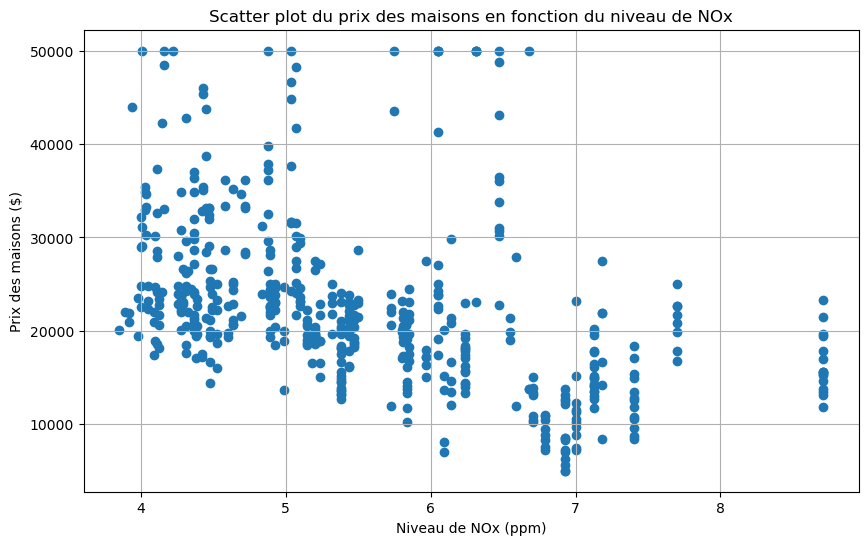

In [8]:
# Plotting the scatter plot of 'nox' vs 'price'
plt.figure(figsize=(10, 6))
plt.scatter(df['nox'], df['price'])
plt.title('Scatter plot du prix des maisons en fonction du niveau de NOx')
plt.xlabel('Niveau de NOx (ppm)')
plt.ylabel('Prix des maisons ($)')
plt.grid(True)
plt.show()

$\underline{Commentaire}$ :  
Non, ce nuage de points ne représente pas un effet ceteris paribus.

Dans une analyse ceteris paribus, nous examinons l'effet de la modification d'une variable tout en gardant toutes les autres constantes. Cependant, dans un nuage de points comme celui créé ici, chaque point de données représente une observation unique où plusieurs variables, y compris _nox_ et _price_, peuvent varier simultanément.

Par conséquent, sans contrôler les autres variables, nous ne pouvons pas isoler l'effet de _nox_ sur _price_ tout en maintenant toutes les autres variables constantes.

Pour effectuer une analyse ceteris paribus, nous utiliserions généralement des techniques telles que l'analyse de régression, où nous pouvons contrôler les effets d'autres variables tout en examinant la relation entre _nox_ et _price_.


#### <span style="color:green"> Q9. Run a regression of <i>price</i> on a <i>constant</i>, <i>crime</i>, <i>nox</i>, <i>rooms</i>, <i>proptax</i>. Comment on the histogram of the residuals. Interpret all coefficients.</span>

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     169.6
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           1.06e-91
Time:                        15:43:41   Log-Likelihood:                -5119.6
No. Observations:                 506   AIC:                         1.025e+04
Df Residuals:                     501   BIC:                         1.027e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.868e+04   3215.205     -5.811      0.0

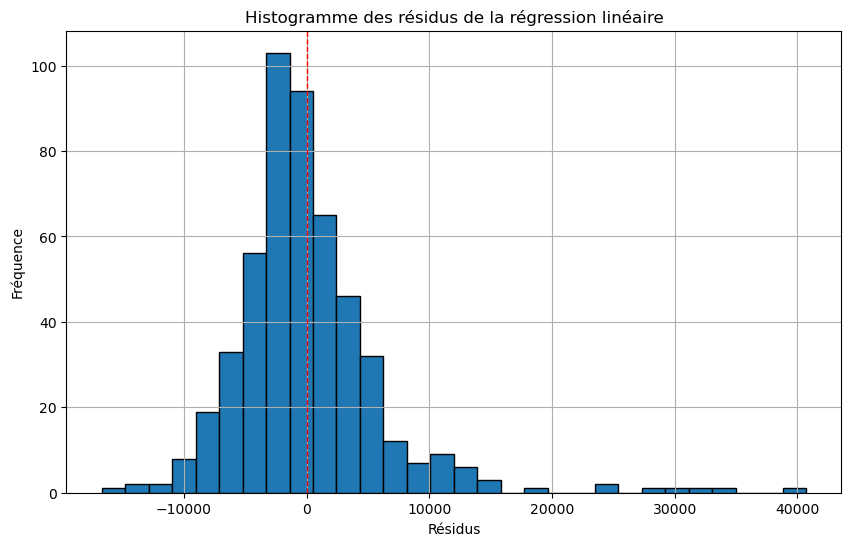

Kurtosis des résidus: 9.781215764345696


In [9]:
# Régression linéaire du prix en fonction d'une constante, de crime, nox, rooms et proptax

# Définition des variables explicatives et de la variable à expliquer
X = df[['crime', 'nox', 'rooms', 'proptax']]
X = sm.add_constant(X)
y = df['price']

# Régression linéaire
model_Q9 = sm.OLS(y, X).fit()

# Affichage des résultats
print(model_Q9.summary())

# Histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(model_Q9.resid, bins=30, edgecolor='black')
plt.title('Histogramme des résidus de la régression linéaire')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.grid(True)

# Ajout de la moyenne
mean_residual = np.mean(model_Q9.resid)
plt.axvline(mean_residual, color='red', linestyle='dashed', linewidth=1)

plt.show()

# Calcul du kurtosis des résidus
kurtosis = model_Q9.resid.kurtosis()
print(f'Kurtosis des résidus: {kurtosis}')

 $\underline{Commentaire-histogramme}$ : La distribution n'est clairement pas normale avec énormément de valeurs élevées (queue vers la droite du graphique appelée aussi "Right-skewed") ce qui est bien mis en valeur par la valeur moyenne (pointillés rouge) n'étant pas centrée et de manière plus rigoureuse par le kurtosis positif des résidus (égal à 0 pour une loi normale).  
   
 $\underline{Commentaire-coefficients}$ :
- Le coefficient de _crime_ est négatif, ce qui suggère qu'une augmentation du taux de criminalité est associée à une baisse du prix des logements.
- Le coefficient de _nox_ est négatif, indiquant qu'une concentration plus élevée d'oxyde d'azote est liée à des prix plus bas.
- **Le coefficient de _rooms_ est positif et est le plus élevé en valeur absolue, indiquant que le nombre de chambres a une influence majeure sur le prix des logements.**
- Le coefficient de _proptax_ est négatif, montrant qu'une taxe foncière plus élevée est associée à des prix de logement inférieurs.
- La constante négative suggère que des prédictions de prix négatifs sont possibles si le modèle est appliqué hors de la portée des données observées, par exemple dans un quartier étudiant (avec une moyenne de chambre proche de 1.  

 $\underline{Commentaire-modèle}$ : **Modèle linéaire \(y = ax + b\)** : 
  Dans ce modèle, augmenter \(x\) d'une unité entraîne une augmentation de \(y\) de \(a\) unités. L'effet est constant, signifiant que pour chaque augmentation unitaire de \(x\), \(y\) augmentera toujours de \(a\).


#### <span style="color:green"> Q10. Run a regression of <i>lprice</i> on a <i>constant</i>, <i>crime</i>, <i>nox</i>, <i>rooms</i>, <i>proptax</i>. Interpret all coefficients.</span>

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     196.9
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          2.50e-101
Time:                        15:43:42   Log-Likelihood:                -26.367
No. Observations:                 506   AIC:                             62.73
Df Residuals:                     501   BIC:                             83.87
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6550      0.137     63.320      0.0

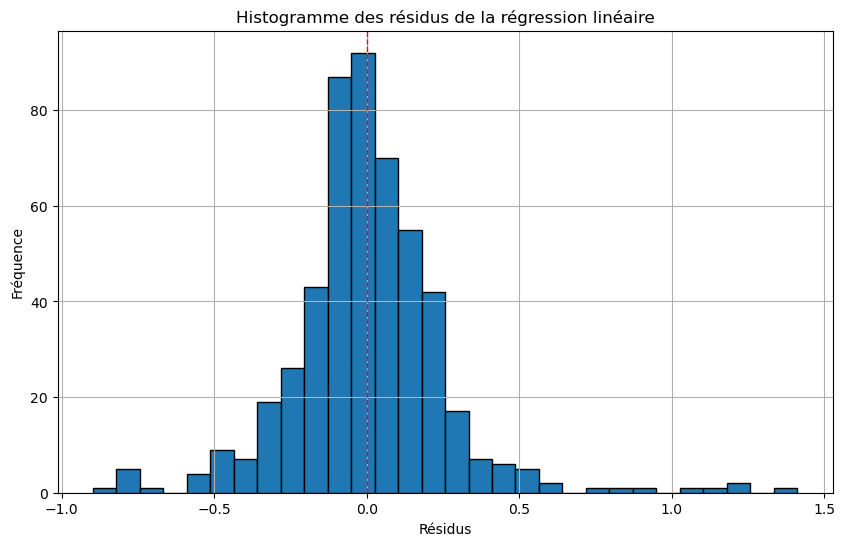

Kurtosis des résidus: 5.696676773957


In [10]:
# Régression linéaire de lprice en fonction d'une constante, de crime, nox, rooms et proptax

# Définition des variables explicatives et de la variable à expliquer
X = df[['crime', 'nox', 'rooms', 'proptax']]
X = sm.add_constant(X)
y = df['lprice']

# Régression linéaire
model_Q10= sm.OLS(y, X).fit()

# Affichage des résultats
print(model_Q10.summary())

# Histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(model_Q10.resid, bins=30, edgecolor='black')
plt.title('Histogramme des résidus de la régression linéaire')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.grid(True)

# Ajout de la moyenne
mean_residual = np.mean(model_Q10.resid)
plt.axvline(mean_residual, color='red', linestyle='dashed', linewidth=1)

plt.show()

# Calcul du kurtosis des résidus
kurtosis = model_Q10.resid.kurtosis()
print(f'Kurtosis des résidus: {kurtosis}')

 $\underline{Commentaire-histogramme}$ : La distribution n'est pas normale avec de nombreuses valeurs élevées (queue vers la droite du graphique appelée aussi "Right-skewed"). Cependant, il y a malgré tout une amélioration avec une diminution du kurtosis avec l'application du logarithme sur le prix.  
   
$\underline{Commentaire-coefficients}$ :
- L'interprétation des coefficients reste semblable, mais la constante positive suggère que l'adoption d'une échelle logarithmique pour le prix assure que les prédictions restent positives.
- L'impact du nombre de chambres, bien qu'il reste le plus important, est moins dominant dans ce modèle.  
  
 $\underline{Commentaire-modèle}$ : **Modèle logarithmique linéaire $log(y) = ax + b$**  
Ici, augmenter \(x\) d'une unité multiplie \(y\) par \(e^a\). L'effet est multiplicative sur \(y\), impliquant que la réaction de \(y\) dépend de sa propre taille : plus \(y\) est grand, plus l'impact absolu d'une augmentation de \(x\) sur \(y\) sera significatif.


#### <span style="color:green"> Q11. Run a regression of <i>lprice</i> on a <i>constant</i>, <i>crime</i>, <i>lnox</i>, <i>rooms</i>, <i>lproptax</i>. Interpret all coefficients.</span>

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     197.4
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          1.77e-101
Time:                        15:43:42   Log-Likelihood:                -26.021
No. Observations:                 506   AIC:                             62.04
Df Residuals:                     501   BIC:                             83.18
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7505      0.253     38.476      0.0

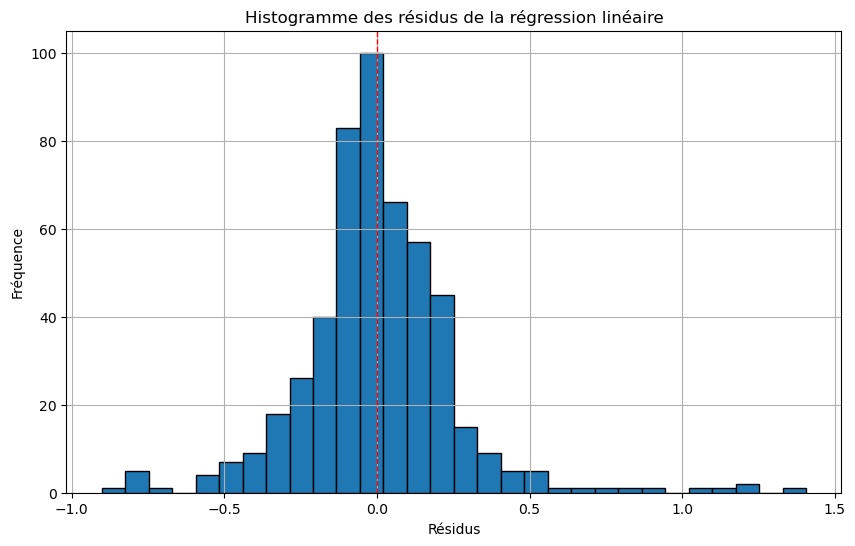

Kurtosis des résidus: 5.652217721881058


In [11]:
# Régression linéaire de lprice en fonction d'une constante, de crime, lnox, rooms et lproptax

# Définition des variables explicatives et de la variable à expliquer
X = df[['crime', 'lnox', 'rooms', 'lproptax']]
X = sm.add_constant(X)
y = df['lprice']

# Régression linéaire
model_Q11 = sm.OLS(y, X).fit()

# Affichage des résultats
print(model_Q11.summary())

# Histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(model_Q11.resid, bins=30, edgecolor='black')
plt.title('Histogramme des résidus de la régression linéaire')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.grid(True)

# Ajout de la moyenne
mean_residual = np.mean(model_Q11.resid)
plt.axvline(mean_residual, color='red', linestyle='dashed', linewidth=1)

plt.show()

# Calcul du kurtosis des résidus
kurtosis = model_Q11.resid.kurtosis()
print(f'Kurtosis des résidus: {kurtosis}')

 $\underline{Commentaire-histogramme}$ : La distribution n'a pas que très peu changé par rapport au graphique précédent. La distribution n'est pas tout à fait normale, le kurtosis en atteste.
   
 $\underline{Commentaire-coefficients}$ :
Les interprétations sont globalement identiques, cependant, les valeurs absolues des coefficients sont beaucoup plus équilibrées.   
Cette remarque est à modérer car lorsque l'on applique une transformation logarithmique à une variable, l'interprétation du coefficient directeur correspondant change également.

- Le coefficient de _lnox_ (a = -0.2769) montre que, toutes choses étant égales par ailleurs, un changement de 1% dans la concentration de _nox_ entraîne une diminution de \(0.2769\)% dans le prix des logements, reflétant l'effet de la pollution de l'air sur les prix.
- Le coefficient de _rooms_ (b = 0.2802) suggère qu'une augmentation d'une unité dans le nombre de chambres est associée à une multiplication du prix des logements par \(e^{0.2802}\), soulignant l'importance de la taille du logement sur son prix.
- Le coefficient de _lproptax_ (-0.1779) indique qu'un changement de 1% dans la taxe foncière est associé à une diminution de \(0.1779\)% dans le prix des logements, mettant en évidence l'impact négatif des taxes plus élevées sur les valeurs immobilières.
- Le coefficient de _crime_ (-0.0128) révèle que l'augmentation du taux de criminalité est liée à une baisse du prix des logements, mais l'effet est moins prononcé que pour les autres variables.

Cette structure du modèle permet de capturer à la fois les effets proportionnels de variables comme _nox_ et _proptax_ (après transformation en logarithme) sur le prix des logements en termes de pourcentage, et les effets linéaires de variables comme _rooms_, permettant une analyse nuancée de la manière dont différents facteurs influencent les prix immobiliers.


 $\underline{Commentaire-Modèle}$ : **Modèle log-log à savoir $log(y) = a \log(x) + b$**  
Dans ce cadre, un changement de 1% dans \(x\) produit un changement de \(a\)% dans \(y\). Cette relation montre que l'effet de \(x\) sur \(y\) est proportionnel : une hausse de \(x\) par un certain pourcentage entraîne une hausse de \(y\) par un pourcentage qui est \(a\) fois celui de \(x\). Ce modèle est précieux pour étudier les relations proportionnelles et les élasticités.  
Certaines variables n'ont pas eu de transformation logarithmique, on retombe sur le cas précédemment vu dans ce cas.



<span style="color:green">

#### Q12. In the specification of question 9, test the hypothesis H0: $\beta_{nox}$ = 0 vs. H1: $\beta_{nox}$ > 0 at the 1% level.

</span>

In [12]:
# Test unilatéral pour beta_nox
t_statistic = model_Q9.tvalues['nox']
p_value_one_sided = model_Q9.pvalues['nox'] / 2  # Diviser par 2 pour le test unilatéral

print(f"T-statistique pour nox: {t_statistic}")
print(f"P-valeur unilatérale pour nox: {p_value_one_sided}")

# Vérification si la p-valeur est inférieure au seuil de signification de 1%
alpha = 0.01
if p_value_one_sided < alpha and t_statistic > 0:
    print("On rejette l'hypothèse nulle H0: beta_nox = 0 au niveau de 1%.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0: beta_nox = 0 au niveau de 1%.")

T-statistique pour nox: -2.0991616888227345
P-valeur unilatérale pour nox: 0.018151217341554424
On ne peut pas rejeter l'hypothèse nulle H0: beta_nox = 0 au niveau de 1%.


 $\underline{Commentaire}$ : Par conséquent, avec un niveau de confiance de 99%, nous ne trouvons pas de preuves suffisantes pour soutenir que l'augmentation de nox entraîne une augmentation du prix des logements.  
 En fait, le coefficient négatif indique plutôt le contraire.

<span style="color:green">

#### Q13. In the specification of question 9, test the hypothesis H0: $\beta_{nox}$ = 0 vs. H1: $\beta_{nox}$ ≠ 0 at the 1% level using the p-value of the test.

</span>

In [13]:
# p_value_nox est la p-value pour le test de la variable 'nox'
p_value_nox = model_Q9.pvalues['nox']
print(f"P-valeur pour nox: {p_value_nox}")

# Seuil de signification pour un test bilatéral au niveau de 1%
alpha = 0.01

# Test de l'hypothèse H0 contre H1 au niveau de 1%
if p_value_nox < alpha:
    print("On rejette l'hypothèse nulle H0: beta_nox = 0 au niveau de 1%.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0: beta_nox = 0 au niveau de 1%.")

P-valeur pour nox: 0.03630243468310885
On ne peut pas rejeter l'hypothèse nulle H0: beta_nox = 0 au niveau de 1%.


 $\underline{Commentaire}$ : Cela signifie que nous n'avons pas suffisamment de preuves pour affirmer que le coefficient de nox est différent de zéro avec un niveau de confiance de 99%. Cela indique que la variable nox n'a pas un effet statistiquement significatif sur le prix des logements à ce niveau de confiance.

<span style="color:green">

#### Q14. In the specification of question 9, test the hypothesis H0: $\beta_{crime}$ = $\beta_{proptax}$ at the 10% level.

</span>

On applique l'idée définie dans le cours n°3 en définissant un paramètre $\theta$ =  $\beta_{crime}$ - $\beta_{proptax}$  
  
Cela donne une équation de la forme :  
$y = const$ + $\theta$ * $crime$ + $\beta_{proptax}$  * ($crime + proptax)$ + $\beta_{nox}$ * $nox + \beta_{rooms} * rooms + u$

In [14]:
# Création d'une colonne avec crime + proptax
df['crime_proptax'] = df['crime'] + df['proptax']

# Définition des variables explicatives et de la variable à expliquer
X = df[['crime', 'crime_proptax', 'nox', 'rooms']]
X = sm.add_constant(X)
y = df['price']

# Régression linéaire
model_Q14 = sm.OLS(y, X).fit()

# Affichage des résultats
print(model_Q14.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     169.6
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           1.06e-91
Time:                        15:43:42   Log-Likelihood:                -5119.6
No. Observations:                 506   AIC:                         1.025e+04
Df Residuals:                     501   BIC:                         1.027e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.868e+04   3215.205     -5.811

In [15]:
# Test de l'hypothèse H0: beta_crime_proptax = 0 contre H1: beta_crime_proptax != 0
p_value = model_Q14.pvalues['crime_proptax']

print(f"P-valeur pour crime_proptax: {p_value}")

# Seuil de signification pour un test bilatéral au niveau de 10%
alpha = 0.10

# Test de l'hypothèse H0 contre H1 au niveau de 10%
if p_value < alpha:
    print("On rejette l'hypothèse nulle H0: beta_crime_proptax = 0 au niveau de 10%.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0: beta_crime_proptax = 0 au niveau de 10%.")

P-valeur pour crime_proptax: 0.00021258433933771186
On rejette l'hypothèse nulle H0: beta_crime_proptax = 0 au niveau de 10%.


 $\underline{Commentaire}$ : Cela signifie que nous avons suffisamment de preuves pour affirmer que le coefficient $\theta$ est différent de zéro avec un niveau de confiance de 90%.  
 Par extension, nous avons suffisamment de preuves pour affirmer que le coefficient $\beta_{crime}$ est différent de $\beta_{proptax}$ avec un niveau de confiance de 90%.

<span style="color:green">

#### Q15. In the specification of question 9, test the hypothesis H0: $\beta_{nox}$ = 0, $\beta_{proptax}$ = 0 at the 10% level.

</span>

##### **Calcul de la somme des carrées des erreurs du modèle non contraint SSR0**

In [16]:
# Définition des variables explicatives et de la variable à expliquer
X = df[['crime', 'nox', 'rooms', 'proptax']]
X = sm.add_constant(X)
y = df['price']

# Régression linéaire
model_Q9 = sm.OLS(y, X).fit()

# Calcul du résidu u
u = model_Q9.resid

# Calcul de la somme des carrées des erreurs du modèle non contraint SSR0
SSR0 = model_Q9.ssr
print(f"SSR0: {SSR0}")

# Calcul des degrés de liberté des résidus du modèle non contraint
df_resid_nc = model_Q9.df_resid
print(f"Degrés de liberté des résidus du modèle non contraint: {df_resid_nc}")

SSR0: 18192596571.936546
Degrés de liberté des résidus du modèle non contraint: 501.0


##### **Calcul de la somme des carrées des erreurs du modèle contraint SSR1**

In [17]:
# Calcul de la somme des carrées des erreurs du modèle contraint SSR1
X = df[['crime', 'rooms']]
X = sm.add_constant(X)
y = df['price']

# Régression linéaire
model = sm.OLS(y, X).fit()

# Calcul du résidu u
u = model.resid

# Calcul de la somme des carrées des erreurs du modèle contraint SSR1
SSR1 = model.ssr
print(f"SSR1: {SSR1}")

# Calcul des degrés de liberté des résidus du modèle contraint
df_resid_c = model.df_resid
print(f"Degrés de liberté des résidus du modèle contraint: {df_resid_c}")

SSR1: 19595081660.211784
Degrés de liberté des résidus du modèle contraint: 503.0


##### **Calcul de la statistique de Fisher F**

In [18]:
from scipy.stats import f

# Calcul de q pour le test de Fisher
q = df_resid_c - df_resid_nc
print(f"q: {q}")

# Calcul de la statistique de Fisher
F = ((SSR1 - SSR0) / q) / (SSR0 / df_resid_nc)
print(f"Statistique de Fisher: {F}")

# Calcul de la p-valeur
p_value = f.sf(F, q, df_resid_nc)
print(f"P-valeur: {p_value}")

# Seuil de signification pour un test bilatéral au niveau de 10%
alpha = 0.10

# Test de l'hypothèse H0 contre H1 au niveau de 10%
if p_value < alpha:
    print("On rejette l'hypothèse nulle H0 au niveau de 10%.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 10%.")

q: 2.0
Statistique de Fisher: 19.311290349552888
P-valeur: 8.332525004918138e-09
On rejette l'hypothèse nulle H0 au niveau de 10%.


$\underline{Commentaire}$ : Nous rejetons l'hypothèse nulle que les coefficients $\beta_{\text{nox}}$ et $\beta_{\text{proptax}}$ sont tous deux égaux à zéro.
Cela signifie que nous avons suffisamment de preuves pour affirmer que les variables nox et proptax ont chacune un effet significatif sur le prix des logements avec un niveau de confiance de 90%.

<span style="color:green">

#### Q16. In the specification of question 9, test the hypothesis H0: $\beta_{nox}$ = -500, $\beta_{proptax}$ = -100 at the 10% level using the p-value of the test.

</span>
  
Le modèle non contraint ne change pas, il nous reste cependant à calculer SSR1 avec les contraintes imposées dans les questions.

##### **Calcul de la somme des carrées des erreurs du modèle contraint SSR1**

In [19]:
# Calcul de la somme des carrées des erreurs du modèle contraint SSR1
X = df[['crime', 'rooms']]
X = sm.add_constant(X)

# Calcul de la variable à expliquer avec les coefficients Beta_nox = -500 et Beta_proptax = -100
y = df['price'] - ( -500 * df['nox'] - 100 * df['proptax'] )

# Régression linéaire
model = sm.OLS(y, X).fit()

# Calcul du résidu u
u = model.resid

# Calcul de la somme des carrées des erreurs du modèle contraint SSR1
SSR1 = model.ssr
print(f"SSR1: {SSR1}")

# Calcul des degrés de liberté des résidus du modèle contraint
df_resid_c = model.df_resid
print(f"Degrés de liberté des résidus du modèle contraint: {df_resid_c}")

SSR1: 18203394906.78485
Degrés de liberté des résidus du modèle contraint: 503.0


##### **Calcul de la statistique de Fisher F**

In [20]:
# Calcul de q pour le test de Fisher
q = df_resid_c - df_resid_nc
print(f"q: {q}")

# Calcul de la statistique de Fisher
F = ((SSR1 - SSR0) / q) / (SSR0 / df_resid_nc)
print(f"Statistique de Fisher: {F}")

# Calcul de la p-valeur
p_value = f.sf(F, q, df_resid_nc)
print(f"P-valeur: {p_value}")

# Seuil de signification pour un test bilatéral au niveau de 10%
alpha = 0.10

# Test de l'hypothèse H0 contre H1 au niveau de 10%
if p_value < alpha:
    print("On rejette l'hypothèse nulle H0 au niveau de 10%.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 10%.")

q: 2.0
Statistique de Fisher: 0.14868591565829475
P-valeur: 0.8618777787518976
On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 10%.


$\underline{Commentaire}$ : Par conséquent, nous ne disposons pas de preuves suffisantes pour rejeter l'hypothèse nulle ($\beta_{\text{nox}}$ = -500, $\beta_{\text{proptax}}$ = -100\) à ce niveau de signification. Cela suggère que, d'après les données et le modèle de régression utilisé dans la question 9, les coefficients pour `nox` et `proptax` ne diffèrent pas de manière significative des valeurs de -500 et -100 respectivement, avec un niveau de confiance de 90%.
  
Cette conclusion parait cohérente puisque les coefficients dans le modèle non contraint sont de -660 pour `nox` et de -89 pour`proptax`, les valeurs sont donc relativement proches du modèle donné par l'OLS.


<span style="color:green">

#### Q17. In the specification of question 9, test the hypothesis that all coefficients are the same for observations with low levels of <i>nox</i> vs. medium and high levels of <i>nox</i>. 
</span>

Le sujet ne semble pas définir de valeur de référence pour alpha.  
Nous prendrons la même hypothèse que précedemment à savoir $\alpha = 10 $%.  
  
**L'astuce pour ce type de question est de bien choisir une catégorie de référence.** Nous choisirons ici la première catégorie à savoir 'low'.

##### **Méthode vue en TP (FAUX MAIS JE PIGE PAS COMMENT CORRIGER)**

In [21]:
# Estimation des coefficients de la régression linéaire pour la catégorie 'low'
X_low_nc = df[df['nox_category'] == 'low'][['crime', 'nox', 'rooms', 'proptax']]
X_low_nc = sm.add_constant(X_low_nc)

y_low_nc = df[df['nox_category'] == 'low']['price']

# Ajustement du modèle OLS pour les faibles niveaux de NOx
model_low_nc = sm.OLS(y_low_nc, X_low_nc).fit()

In [22]:
# Estimation des coefficients de la régression linéaire pour la catégorie 'medium' et 'high'
x_medium_high = df[df['nox_category'] != 'low'][['crime', 'nox', 'rooms', 'proptax']]
x_medium_high_c = sm.add_constant(x_medium_high)[["const"]]

y_medium_high = df[df['nox_category'] != 'low']['price']

y_medium_high_c = (
    y_medium_high
    - model_low_nc.params["crime"] * x_medium_high["crime"]
    - model_low_nc.params["nox"] * x_medium_high["nox"]
    - model_low_nc.params["rooms"] * x_medium_high["rooms"]
    - model_low_nc.params["proptax"] * x_medium_high["proptax"]
)

# Ajustement du modèle OLS pour les niveaux de NOx moyens et élevés
model_contraint = sm.OLS(y_medium_high_c, x_medium_high_c)
model_medium_high_c = model_contraint.fit()

# Test de Fisher
SSR_low_nc = model_low_nc.ssr
SSR_medium_high_c = model_medium_high_c.ssr

df_nc = X_low_nc.shape[1] - 1
df_c = x_medium_high_c.shape[1] - 1

# Calcul de q pour le test de Fisher
q = df_nc - df_c
print(f"q: {q}")

ddf = n - df_nc - 1
print(f"ddf: {ddf}")

# Calcul de la statistique de Fisher
F = ((SSR_medium_high_c - SSR_low_nc) / q) / (SSR_low_nc / df_nc)
print(f"Statistique de Fisher: {F}")

# Calcul de la p-valeur
p_value = f.sf(F, q, df_nc)
print(f"P-valeur: {p_value}")

# Seuil de signification pour un test bilatéral au niveau de 5%
alpha = 0.10

# Test de l'hypothèse H0 contre H1 au niveau de 5%
if p_value < alpha:
    print("On rejette l'hypothèse nulle H0 au niveau de 5%.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 5%.")
    

q: 4
ddf: 501
Statistique de Fisher: 21.189712007314352
P-valeur: 0.005909761823016975
On rejette l'hypothèse nulle H0 au niveau de 5%.


##### **Méthode alternative à celle vue en cours**

L'objectif est ici plutôt de tester l'hétérogénéité des effets des variables explicatives à travers les niveaux de NOx dans un cadre global avec des termes d'interaction.  
Cela teste indirectement si les relations dans le sous-groupe à faible NOx diffèrent de celles dans les sous-groupes à moyen et haut NOx.
  
Cette démarche que nous avons pu trouvé dans la littérature nous a semblé plus rigoureuse que la méthode initiale abordée en TP.

In [23]:
# Création de variables d'interaction pour les catégories 'medium' et 'high'
df['medium'] = (df['nox_category'] == 'medium').astype(int)
df['high'] = (df['nox_category'] == 'high').astype(int)

# Création des interactions
for var in ['crime', 'nox', 'rooms', 'proptax']:
    df[f'{var}_medium'] = df[var] * df['medium']
    df[f'{var}_high'] = df[var] * df['high']

# Préparation du modèle avec les interactions
X_interactions = df[['crime', 'nox', 'rooms', 'proptax', 
                     'crime_medium', 'nox_medium', 'rooms_medium', 'proptax_medium',
                     'crime_high', 'nox_high', 'rooms_high', 'proptax_high']]
X_interactions = sm.add_constant(X_interactions)

# Régression linéaire avec interactions
model_interactions = sm.OLS(y, X_interactions).fit()

# Test global pour voir si les coefficients pour 'medium' et 'high' diffèrent de 'low'
# Cela se fait par un test F de la restriction que tous les coefficients d'interaction sont zéro
results_F_test = model_interactions.f_test(np.identity(len(model_interactions.params))[1:])

print(f"Statistique F: {results_F_test.fvalue}")
print(f"P-value: {results_F_test.pvalue}")

# Seuil de signification pour un test bilatéral au niveau de 10%
alpha = 0.1 

# Conclusion du test d'hypothèse
if results_F_test.pvalue < alpha:
    print("On rejette l'hypothèse nulle au niveau de 10% : les effets ne sont pas les mêmes pour toutes les catégories de NOx.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle au niveau de 10% : pas de preuve que les effets diffèrent entre les catégories de NOx.")


Statistique F: 48.108197618301595
P-value: 3.863325517276756e-75
On rejette l'hypothèse nulle au niveau de 10% : les effets ne sont pas les mêmes pour toutes les catégories de NOx.


$\underline{Commentaire}$ : Par conséquent, nous disposons de preuves suffisantes pour rejeter l'hypothèse nulle (tous les coefficients sont les mêmes indépendemment du groupe pour les `nox` à savoir 'low', 'medium' et 'high') avec un niveau de confiance de 90 %.  
Cette différence suggère que l'impact des variables considérées dans notre modèle sur le prix des logements n'est pas constant à travers les différentes catégories de concentration de NOx. En conséquence, cela indique que les variations dans le niveau de NOx interagissent avec ces variables pour influencer le prix des logements de manière différente selon que l'on se trouve dans une zone à faible, moyenne ou haute concentration de NOx. 

<span style="color:green">

#### Q18. Repeat the test of question 17 but now assuming that only the coefficients of <i>nox</i> and <i>proptax</i> can change between the two groups of observations. State and test $H_{0}$.

</span>

In [24]:
# Création de variables d'interaction uniquement pour 'nox' et 'proptax' entre les niveaux de NOx
df['nox_medium'] = df['nox'] * df['medium']
df['nox_high'] = df['nox'] * df['high']
df['proptax_medium'] = df['proptax'] * df['medium']
df['proptax_high'] = df['proptax'] * df['high']

# Préparation du modèle avec les interactions pour 'nox' et 'proptax' uniquement
X_interactions_specific = df[['crime', 'nox', 'rooms', 'proptax', 
                              'nox_medium', 'proptax_medium', 
                              'nox_high', 'proptax_high']]
X_interactions_specific = sm.add_constant(X_interactions_specific)

# Régression linéaire avec interactions spécifiques
model_interactions_specific = sm.OLS(y, X_interactions_specific).fit()

# Test F pour les interactions spécifiques de 'nox' et 'proptax'
# Construire une matrice d'identité ajustée pour tester uniquement les interactions spécifiques
num_params = len(model_interactions_specific.params)
identity_matrix_specific = np.identity(num_params)[[5, 6, 7, 8], :]  # Ajuster les indices pour les interactions

results_F_test_specific = model_interactions_specific.f_test(identity_matrix_specific)

print(f"Statistique F spécifique: {results_F_test_specific.fvalue}")
print(f"P-valeur spécifique: {results_F_test_specific.pvalue}")

# Conclusion du test d'hypothèse spécifique
if results_F_test_specific.pvalue < alpha:
    print("On rejette l'hypothèse nulle au niveau de 10% : les effets de 'nox' et 'proptax' ne sont pas les mêmes pour toutes les catégories de NOx.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle au niveau de 10% : pas de preuve que les effets de 'nox' et 'proptax' diffèrent entre les catégories de NOx.")


Statistique F spécifique: 2.209818059831535
P-valeur spécifique: 0.06686244546473936
On rejette l'hypothèse nulle au niveau de 10% : les effets de 'nox' et 'proptax' ne sont pas les mêmes pour toutes les catégories de NOx.


$\underline{Commentaire}$ : Nous rejetons l'hypothèse nulle au niveau de signification de 10%. Cela indique que les effets de nox et proptax sur le prix des logements varient significativement entre les catégories de faibles et de moyens/élevés niveaux de NOx avec un niveau de confiance de 90%.  
Ce résultat suggère que les interactions entre les niveaux de NOx et ces deux variables explicatives sont statistiquement significatives, impliquant que l'impact de la pollution par le NOx et du taux de la taxe foncière sur le prix des logements n'est pas uniforme à travers tous les niveaux de NOx. Ainsi, les politiques et les analyses qui ne tiennent pas compte de ces variations pourraient ne pas refléter fidèlement la réalité des effets sur le marché immobilier.

## <span style="color:red">PARTIE 2 - HETEROSKEDASTICITY</span>
Cette partie utilise le jeu de données HPRICE2.RAW décrit dans HPRICE2.DES.

#### <span style="color:green">  Q19. Explain the problem of heteroskedasticity with an example of the course.</span>

L'hétéroscédasticité signifie que la variance des erreurs `u`  dans un modèle de régression n'est pas constante parmi toutes les observations. Cela pose problème car l'une des hypothèses clés de la régression linéaire classique est que ces variances sont identiques, permettant des estimations fiables et des tests statistiques valides.

Prenons l'exemple des dépenses de consommation en fonction du revenu des ménages. Si, à mesure que le revenu augmente, la variabilité des dépenses augmente aussi (les ménages riches dépensent de manière plus variable que les ménages pauvres), cela indique une hétéroscédasticité. Cela peut se manifester par une dispersion des résidus qui s'élargit avec l'augmentation du revenu.

Cette situation rend les estimations des écarts-types des coefficients biaisées, affectant la fiabilité des tests de significativité et des intervalles de confiance. Bien que les coefficients restent non biaisés, ils ne sont plus les estimations les plus efficaces. Pour corriger l'hétéroscédasticité, on peut transformer les variables ou utiliser des méthodes de pondération. Des tests comme ceux de White ou Breusch-Pagan permettent de détecter formellement cette condition.

<span style="color:green">

#### Q20. In the specification of question 9, test the hypothesis of no heteroskedasticity of linear form, i.e. in the regression of $u^{2}$ on constant, crime, nox, rooms, proptax, test $H_{0}$: $\delta_{crime}$, $\delta_{nox}$, $\delta_{room}$, $\delta_{proptax}$ = 0, where the coefficients $\delta_{k}$ (k = crime, nox, rooms, proptax) are associated with the corresponding explanatory variables.

</span>

La consigne ne précise pas de seuil pour le test. Nous prendrons une valeur $\alpha = 10 $%.  

In [25]:
# Nous créons une fonction pour tester l'hétéroscédasticité afin de rendre le code plus compact

def test_heteroscedasticity(data, dependent_var, independent_vars, alpha=0.10):
    # Préparation des données
    X = data[independent_vars]
    X = sm.add_constant(X)
    y = data[dependent_var]

    # Ajustement du modèle de base
    model_base = sm.OLS(y, X).fit()
    u = model_base.resid
    u2 = u**2

    # Régression sur les résidus au carré
    model_with_u2 = sm.OLS(u2, X).fit()

    # Récupération des résultats
    F = model_with_u2.fvalue
    p_value = model_with_u2.f_pvalue

    # Affichage des résultats
    print(f"F-statistic: {F}")
    print(f"P-value: {p_value}")

    # Test de l'hypothèse d'homoscédasticité
    if p_value < alpha:
        print("On rejette l'hypothèse nulle H0 au niveau de 10%. Il y a donc hétéroscédasticité.")
    else:
        print("On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 10%. Il n'y a pas d'hétéroscédasticité.")

# Utilisation de la fonctions
test_heteroscedasticity(df, 'price', ['crime', 'nox', 'rooms', 'proptax'])


F-statistic: 6.7988932530913475
P-value: 2.4672073438899615e-05
On rejette l'hypothèse nulle H0 au niveau de 10%. Il y a donc hétéroscédasticité.


$\underline{Commentaire}$ : L'hétéroscédasticité est présente dans le modèle de régression linéaire avec un niveau de confiance de 90%. Cela pourrait indiquer que l'effet des variables indépendantes sur la variable dépendante change en fonction du niveau de ces variables, ou que certaines variables explicatives importantes sont peut-être omises du modèle.

#### <span style="color:green">Q21. In the specification of question 10, test the hypothesis of no heteroskedasticity of linear form.</span>

In [26]:
test_heteroscedasticity(df, 'lprice', ['crime', 'nox', 'rooms', 'proptax'])

F-statistic: 17.97638257131352
P-value: 8.329911128384759e-14
On rejette l'hypothèse nulle H0 au niveau de 10%. Il y a donc hétéroscédasticité.


$\underline{Commentaire}$ : La méthode et les résultats sont similaires. Il y a bien hétéroscédasticité.  
La p-valeur augmente, indiquant un renforcement de l'hétéroscédasticité.

#### <span style="color:green">Q22. In the specification of question 11, test the hypothesis of no heteroskedasticity of linear form.</span>

In [27]:
test_heteroscedasticity(df, 'lprice', ['crime', 'lnox', 'rooms', 'lproptax'])

F-statistic: 16.509872938658816
P-value: 1.0205916389174496e-12
On rejette l'hypothèse nulle H0 au niveau de 10%. Il y a donc hétéroscédasticité.


$\underline{Commentaire}$ : La méthode et les résultats sont similaires. Il y a bien hétéroscédasticité dans ce cas.

#### <span style="color:green">Q23. Comment on the differences between your results of questions 20,21,22. </span>

Ces résultats indiquent que les transformations logarithmiques, bien qu'utiles en règle générale, ne suffisent pas à résoudre le problème de l'hétéroscédasticité dans ces données (elles empirent même les résultats dans le cas présent).  
  
Il est possible que ces transformations aient renforcé la visibilité des inégalités de variance, notamment si certaines des variables explicatives ont une relation non linéaire avec la variable dépendante. Cela indique que des modèles plus complexes pourraient être nécessaires pour corriger l'hétéroscédasticité, tels que des transformations différentes ou **l'inclusion de variables omises pertinentes**.

<span style="color:green">

#### Q24. Regardless of the results of the test of question 22, identify the most significant variable causing heteroskedasticity using the student statistics and run a WLS regression with the identified variable as weight. 

</span>

##### **Variable la plus significative sur l'hétéroscédasticité**

In [28]:
# Définition des variables explicatives et de la variable à expliquer
X = df[['crime', 'nox', 'rooms', 'proptax']]
X = sm.add_constant(X)
y = df['price']

# Obtention des résidus du modèle de base
model_base = sm.OLS(y, X).fit()
u = model_base.resid
u2 = u**2

# Modification du modèle pour inclure les résidus au carré
y = u2
model_avec_u2 = sm.OLS(y, X).fit()

# Calcul des statistiques t pour chaque variable explicative
t_statistics = model_avec_u2.tvalues

# Identifier la variable avec la statistique t la plus élevée en valeur absolue
max_t_stat = t_statistics.abs().idxmax()
print(f"Variable avec la plus grande valeur absolue de la statistique t: {max_t_stat}")

Variable avec la plus grande valeur absolue de la statistique t: proptax


##### **Modèle de régression WLS**

In [29]:
# Poids pour la régression WLS : inverse des résidus au carré de la variable la plus significative
weights = 1 / df[max_t_stat]**2

# Exécuter une régression WLS avec les poids identifiés
model_wls = sm.WLS(y, X, weights=weights).fit()

# Afficher le résumé du modèle WLS
print(model_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            WLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     8.828
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           6.81e-07
Time:                        15:43:42   Log-Likelihood:                -9895.4
No. Observations:                 506   AIC:                         1.980e+04
Df Residuals:                     501   BIC:                         1.982e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.581e+08   3.68e+07     -4.293      0.0

##### **Impact du nouveau modèle sur l'hétéroscédasticité**

In [30]:
# Test d'hétéroscédasticité sur les résidus du modèle WLS
u_wls = model_wls.resid
u2_wls = u_wls**2
model_avec_u2_wls = sm.OLS(u2_wls, X).fit()

# Calcul et impression de la statistique F et de la p-value pour le modèle WLS
F_wls = model_avec_u2_wls.fvalue
p_value_wls = model_avec_u2_wls.f_pvalue

print(f"F-statistic: {F_wls}")
print(f"P-value: {p_value_wls}")

# Décision basée sur la p-value
if p_value_wls < alpha:
    print("On rejette l'hypothèse nulle H0 au niveau de 10%. Il y a donc hétéroscédasticité après WLS.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 10%. Il n'y a pas d'hétéroscédasticité après WLS.")


F-statistic: 4.418015939319159
P-value: 0.0016143923788151033
On rejette l'hypothèse nulle H0 au niveau de 10%. Il y a donc hétéroscédasticité après WLS.


$\underline{Commentaire}$ : La variable proptax est celle qui influence le plus l'hétéroscédasticité.
  
Malgré la mise en œuvre de la régression WLS, l'hétéroscédasticité reste significative dans notre modèle, comme le montre le rejet de l'hypothèse nulle. Néanmoins, la diminution de la F-statistique et l'augmentation de la p-valeur par rapport au modèle OLS initial indique que la régression WLS a eu un impact positif en réduisant l'hétéroscédasticité.  
  
De plus, une valeur de r&sup2; égale à 0.066 dans le modèle WLS souligne que ce modèle linéaire n'explique qu'une petite partie de la variabilité de la variable dépendante. Cela indique que, bien que le WLS ait pu atténuer l'hétéroscédasticité, il ne capte pas efficacement les dynamiques complexes de nos données

## <span style="color:red"> PARTIE 3 - TIME SERIES DATA</span>

Cette partie utilise l'ensemble de données threecenturies_v2.3. Importez le PIB réel aux prix du marché, le taux de chômage et l'inflation des prix à la consommation pour la période 1900-2000 en Python à partir de la feuille de calcul A1.

In [31]:
# Charger le DataFrame depuis le fichier Excel
df = pd.read_excel("./data/threecenturies_v2.3.xlsx", sheet_name="A1. Headline series", usecols=[1, 15, 28])

# Sélection des rangées pour la période 1900-2000
realGDP = df.iloc[246:347, 0].reset_index(drop=True)
unemployment = df.iloc[246:347, 1].reset_index(drop=True)
inflation = df.iloc[246:347, 2].reset_index(drop=True)

# Création d'un nouveau DataFrame avec les séries sélectionnées
df = pd.DataFrame({"realGDP": realGDP, "unemployment": unemployment, "inflation": inflation})

# Affichage des premières lignes du DataFrame
df.head()

,realGDP,unemployment,inflation
0,181160.264436,3.679865,4.058273
1,184974.529384,4.877351,-0.3
2,187756.550527,5.145694,0
3,186015.76815,5.603507,1.10331
4,188155.559259,6.914821,-0.396825


In [32]:
df.shape

(101, 3)

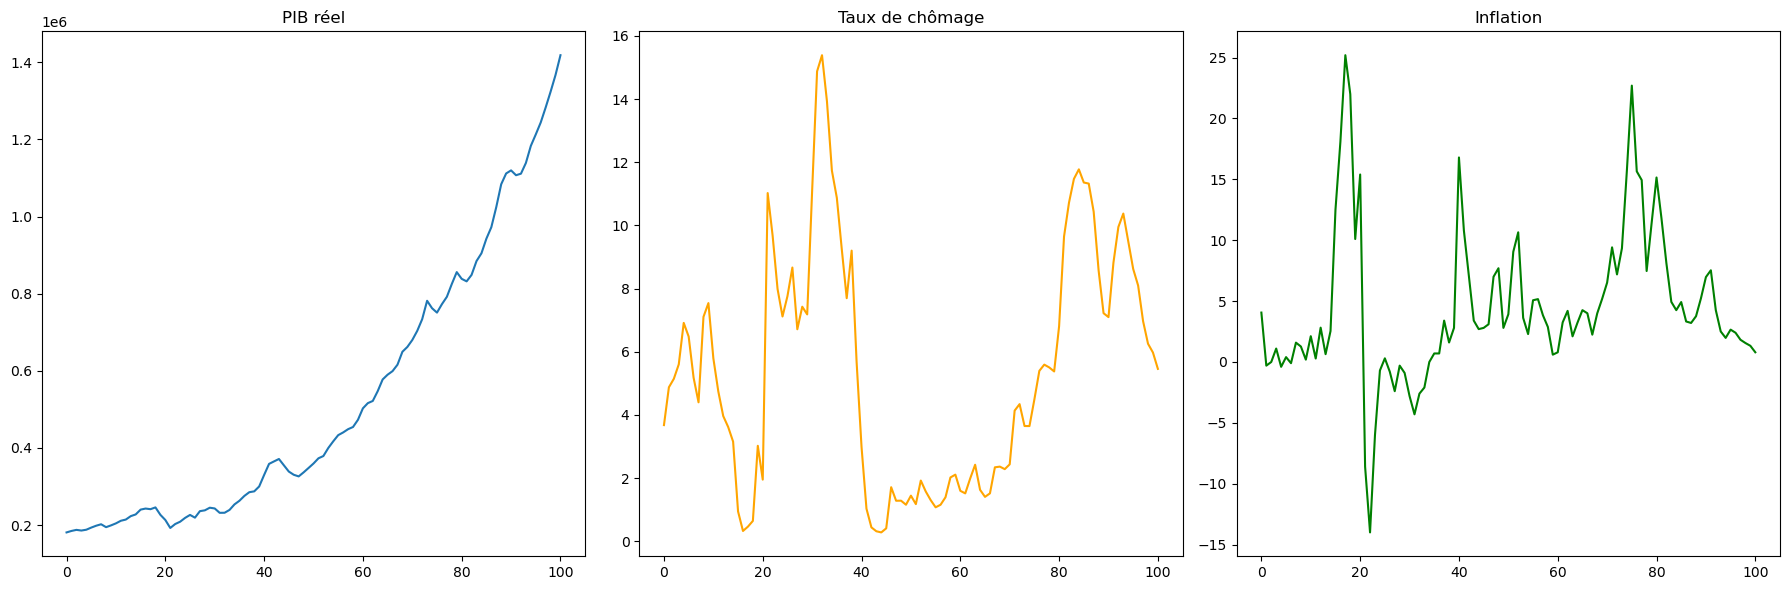

In [33]:
# Tracé des 3 séries temporelles dans 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tracé de la série temporelle du PIB réel
axes[0].plot(df["realGDP"])
axes[0].set_title("PIB réel")

# Tracé de la série temporelle du taux de chômage
axes[1].plot(df["unemployment"], color="orange")
axes[1].set_title("Taux de chômage")

# Tracé de la série temporelle de l'inflation
axes[2].plot(df["inflation"], color="green")
axes[2].set_title("Inflation")

plt.tight_layout()
plt.show()

#### <span style="color:green"> Q25. Define strict and weak stationarity.</span>

Dans le contexte des séries temporelles, une série est dite **strictement stationnaire** si la distribution conjointe de $X_{t_1}, X_{t_2}, \dots, X_{t_k}$ est identique à celle de $X_{t_1+h}, X_{t_2+h}, \dots, X_{t_k+h}$ pour tout $k$ et tout $h \geq 1$. Cette définition exige que toutes les propriétés statistiques restent constantes dans le temps, peu importe le décalage temporel $h$.

Une hypothèse plus faible de la stationnarité est celle de **stationnarité faible**. Une série est considérée comme faiblement stationnaire si la moyenne et la variance de $X_t$ sont constantes dans le temps, et si la covariance entre $X_t$ et $X_{t+h}$ ne dépend que de $h$ et non du temps $t$ lui-même. Autrement dit, pour une série faiblement stationnaire, ce qui compte, c’est l'écart entre les observations et non quand elles sont prises. De plus, pour qu'une série soit faiblement stationnaire, son second moment doit exister.

Ces concepts sont cruciaux en économétrie des séries temporelles car ils influencent la manière dont nous modélisons et prévoyons les données économiques et financières. Des processus stationnaires simplifient l'analyse en permettant l'utilisation de techniques statistiques classiques, tandis que la non-stationnarité nécessite des approches plus complexes, telles que la différenciation ou la modélisation de tendance.

#### <span style="color:green"> Q26. Explain ergodicity and state the ergodic theorem. Illustrate with an example.</span>

En économétrie des séries temporelles, un processus est dit **ergodique** si, sur le long terme, il "oublie" ses conditions initiales, tendant vers une forme d'indépendance asymptotique. Cela signifie que, même si des valeurs éloignées dans le temps peuvent être corrélées, cette corrélation s'affaiblit avec l'augmentation de l'écart temporel, permettant à la moyenne temporelle d'une série de converger vers sa moyenne spatiale (ou espérance).

Le **théorème ergodique** formalise cette notion en affirmant que pour un processus strictement stationnaire et ergodique, avec une espérance finie quand T tend vers l'infini, la moyenne temporelle converge vers la moyenne spatiale (l'espérance).

**Exemple :** Prenons l'exemple d'une épargne annuelle investie dans un fonds d'investissement stable, où les retours annuels sont influencés par une combinaison aléatoire de facteurs économiques. Selon l'ergodicité, même si les retours peuvent varier considérablement d'une année à l'autre, sur une longue période, le taux de rendement moyen de l'investissement tendra vers une certaine moyenne stable. Cela signifie que malgré la volatilité annuelle, la performance moyenne à long terme de l'investissement sera prévisible et reflétera la tendance générale du marché. Cela permet aux investisseurs de planifier sur la base de rendements moyens attendus, même si la trajectoire exacte de l'investissement d'une année à l'autre est imprévisible.


#### <span style="color:green"> Q27. Why do we need both stationarity and ergodicity?</span>

La **stationnarité** et l'**ergodicité** sont essentielles en économétrie des séries temporelles car elles garantissent la fiabilité et la prédictibilité des modèles. La **stationnarité** assure que les propriétés statistiques de la série, comme la moyenne et la variance, restent constantes dans le temps, ce qui est crucial pour l'utilisation de techniques statistiques classiques. Sans stationnarité, les prédictions basées sur des observations passées peuvent devenir non représentatives à mesure que la série évolue.

L'**ergodicité**, d'autre part, permet de tirer des conclusions sur l'ensemble de la distribution d'une série à partir d'une seule réalisation de cette série au fil du temps. Cela signifie qu'en observant une trajectoire temporelle, nous pouvons inférer les propriétés statistiques globales du processus. En l'absence d'ergodicité, même une série stationnaire pourrait ne pas permettre de faire des inférences fiables sur ses propriétés à long terme.

Ensemble, la stationnarité et l'ergodicité fournissent un cadre solide pour modéliser et prévoir les séries temporelles, permettant des analyses statistiques valides et des prédictions fiables basées sur des données historiques.

#### <span style="color:green"> Q28. Explain “spurious regression”.</span>

Une **régression fallacieuse** se produit lorsqu'une analyse de régression suggère à tort qu'il existe une relation significative entre des variables indépendantes et dépendantes, principalement à cause de leur tendance commune dans le temps plutôt que d'une véritable relation causale. Cela arrive souvent avec des séries temporelles non stationnaires, où les variables évoluent au fil du temps d'une manière qui crée l'illusion de corrélation. Par exemple, si deux séries temporelles croissent simplement à cause d'une tendance, une régression de l'une sur l'autre pourrait indiquer une forte corrélation même en l'absence de relation causale.

Pour illustrer, considérons deux séries : l'une représentant la consommation de thé en Angleterre et l'autre le salaire minimum aux États-Unis sur une longue période. Même si ces deux séries sont susceptibles d'augmenter au fil du temps en raison de l'inflation et d'autres facteurs économiques, une régression de la consommation de thé sur le salaire minimum pourrait montrer une corrélation "significative", illustrant une régression fallacieuse en l'absence d'une relation causale réelle entre les deux.

#### <span style="color:green"> Q29. Make all time series stationary by computing the difference between the original variable and a moving average of order 10.</span>

In [34]:
# Calcul de la moyenne mobile sur 10 périodes
df_mm_10 = df.rolling(window=10).mean()

# Calcul des séries stationnaires
df_stationnaire_10 = df - df_mm_10

# Suppression des valeurs manquantes
df_stationnaire_10.dropna(inplace=True)

# Affichage des premières lignes du DataFrame
df_stationnaire_10.head(10)

,realGDP,unemployment,inflation
9,7712.000143,1.847968,-0.588616
10,10614.61538,-0.110816,1.531676
11,14725.156808,-1.144309,-0.363068
12,15173.59111,-1.807121,1.893895
13,20276.89286,-1.954965,-0.24158
14,20759.272987,-2.04331,1.369207
15,28601.374835,-3.697889,10.113593
16,26857.812341,-3.831977,13.893673
17,21350.941496,-3.301363,18.63256
18,20826.724226,-2.474466,13.359638


$\underline{Commentaire}$ : Comme nous pouvons le voir, ici, notre dataframe contient des valeurs "NaN", plusieurs méthodes s'offrent à nous pour les traiter (mettre une valeur égale à 0 pour les 9 premières valeurs de df_mm_10 par exemple ce qui permet de conserver par défaut les valeurs d'origine).  
Cependant et pour rester cohérent avec ce que nous avons fait en TP, nous avons décidé d'ignorer ces valeurs en les enlevant de notre dataframe.

#### <span style="color:green"> Q30. Using the original dataset, test the unit root hypothesis for all variables.</span>

##### **Sans différenciation de régression (constante de base)**

La méthode ci-dessous est celle que nous avons employé en TP.

In [35]:
# Fonction pour effectuer le test de Dickey-Fuller augmenté sur une série temporelle
def test_unit_root(series, variable_name):
    result = adfuller(series, autolag='AIC')  # Sélection automatique du lag
    print(f"Résultats du test de Dickey-Fuller augmenté pour {variable_name}:")
    print(f"Statistique de test ADF: {result[0]}")
    print(f"P-value: {result[1]}")
    print("Valeurs critiques:", result[4])
    if result[1] < 0.05:
        print(f"Conclusion: {variable_name} n'a pas de racine unitaire, série stationnaire à 5% de niveau de signification.\n")
    else:
        print(f"Conclusion: {variable_name} a une racine unitaire, série non stationnaire.\n")

In [36]:
# Appliquer le test à chaque variable
test_unit_root(df['realGDP'], 'RealGDP')
test_unit_root(df['unemployment'], 'Unemployment')
test_unit_root(df['inflation'], 'Inflation')

Résultats du test de Dickey-Fuller augmenté pour RealGDP:
Statistique de test ADF: 4.334307365243232
P-value: 1.0
Valeurs critiques: {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}
Conclusion: RealGDP a une racine unitaire, série non stationnaire.

Résultats du test de Dickey-Fuller augmenté pour Unemployment:
Statistique de test ADF: -2.363202931618559
P-value: 0.15239250945749527
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: Unemployment a une racine unitaire, série non stationnaire.

Résultats du test de Dickey-Fuller augmenté pour Inflation:
Statistique de test ADF: -4.050359167255832
P-value: 0.001168599408868904
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: Inflation n'a pas de racine unitaire, série stationnaire à 5% de niveau de signification.



$\underline{Commentaire}$ : Les séries du PIB réel et du taux de chômage ne sont pas stationnaire ce qui correspond bien aux observations graphique.
La série de l'inflation semble en effet stationnaire puisque elle tend vers une valeur moyenne sur le long terme aux environs de 3%.  
  
Cependant, il nous semble judicieux de compléter notre étude de stationnarité en testant la série N°1 (PIB) à l'aide d'une régression avec tendance et constante étant donné sa forme globale. Les séries 2 et 3 seront testées avec une régression constante, nous devrions à priori obtenir les mêmes résultats.

##### **Avec différenciation de régression constante et tendance pour RealGDP et constante pour Unemployment et Inflation**

In [37]:
# Fonction pour effectuer le test de Dickey-Fuller augmenté sur une série temporelle
def test_unit_root_v2(series, variable_name):
    if variable_name == 'RealGDP': # Utilisation de la régression avec constante et tendance pour RealGDP
        result = adfuller(series, autolag='AIC', regression='ctt') # Sélection automatique du lag
    else: # Utilisation de la régression avec constante pour Unemployment et Inflation
        result = adfuller(series, autolag='AIC', regression='c') # Sélection automatique du lag
    print(f"Résultats du test de Dickey-Fuller augmenté pour {variable_name}:")
    print(f"Statistique de test ADF: {result[0]}")
    print(f"P-value: {result[1]}")
    print("Valeurs critiques:", result[4])
    if result[1] < 0.05:
        print(f"Conclusion: {variable_name} n'a pas de racine unitaire, série stationnaire à 5% de niveau de signification.\n")
    else:
        print(f"Conclusion: {variable_name} a une racine unitaire, série non stationnaire.\n")

In [38]:
# Appliquer le test à chaque variable
test_unit_root_v2(df['realGDP'], 'RealGDP')
test_unit_root_v2(df['unemployment'], 'Unemployment')
test_unit_root_v2(df['inflation'], 'Inflation')

Résultats du test de Dickey-Fuller augmenté pour RealGDP:
Statistique de test ADF: -3.7862421043764996
P-value: 0.05647742559169279
Valeurs critiques: {'1%': -4.492181424560883, '5%': -3.893439799803978, '10%': -3.590831208050302}
Conclusion: RealGDP a une racine unitaire, série non stationnaire.

Résultats du test de Dickey-Fuller augmenté pour Unemployment:
Statistique de test ADF: -2.363202931618559
P-value: 0.15239250945749527
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: Unemployment a une racine unitaire, série non stationnaire.

Résultats du test de Dickey-Fuller augmenté pour Inflation:
Statistique de test ADF: -4.050359167255832
P-value: 0.001168599408868904
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: Inflation n'a pas de racine unitaire, série stationnaire à 5% de niveau de signification.



$\underline{Commentaire}$ : Les résultats n'ont pas changé.
Cependant, avec cette méthode, nous sommes passés très près d'avoir une série stationnaire pour la série du PIB (série 1) avec une hypothèse de régression avec tendance et constante à 5% de niveau de signification puisque nous avons obtenu p=0.056.  
  
Notre démarche a donc eu un interêt certain et aurait pu démontrer une stationnarité avec un niveau de confiance de 90%

#### <span style="color:green"> Q31. Transform all variables so that they are stationary using either your answers to questions 29 or to question 30.</span>

In [39]:
# Transformation des séries temporelles en séries stationnaires de différence
df_diff = df.diff().dropna()

# Vérification de la stationnarité des séries temporelles transformées
test_unit_root(df_diff['realGDP'], 'RealGDP')
test_unit_root(df_diff['unemployment'], 'Unemployment')
test_unit_root(df_diff['inflation'], 'Inflation')

Résultats du test de Dickey-Fuller augmenté pour RealGDP:
Statistique de test ADF: -4.612330316899264
P-value: 0.0001225762758012799
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: RealGDP n'a pas de racine unitaire, série stationnaire à 5% de niveau de signification.

Résultats du test de Dickey-Fuller augmenté pour Unemployment:
Statistique de test ADF: -8.563654592418079
P-value: 8.561099598396381e-14
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: Unemployment n'a pas de racine unitaire, série stationnaire à 5% de niveau de signification.

Résultats du test de Dickey-Fuller augmenté pour Inflation:
Statistique de test ADF: -9.690380421215028
P-value: 1.1406945366153447e-16
Valeurs critiques: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Conclusion: Inflation n'a pas de racine unitaire, série stationnaire à 5% de niveau de

  $\underline{Commentaire}$ : Nous obtenons bien 3 séries stationnaires avec un niveau de confiance de 95%

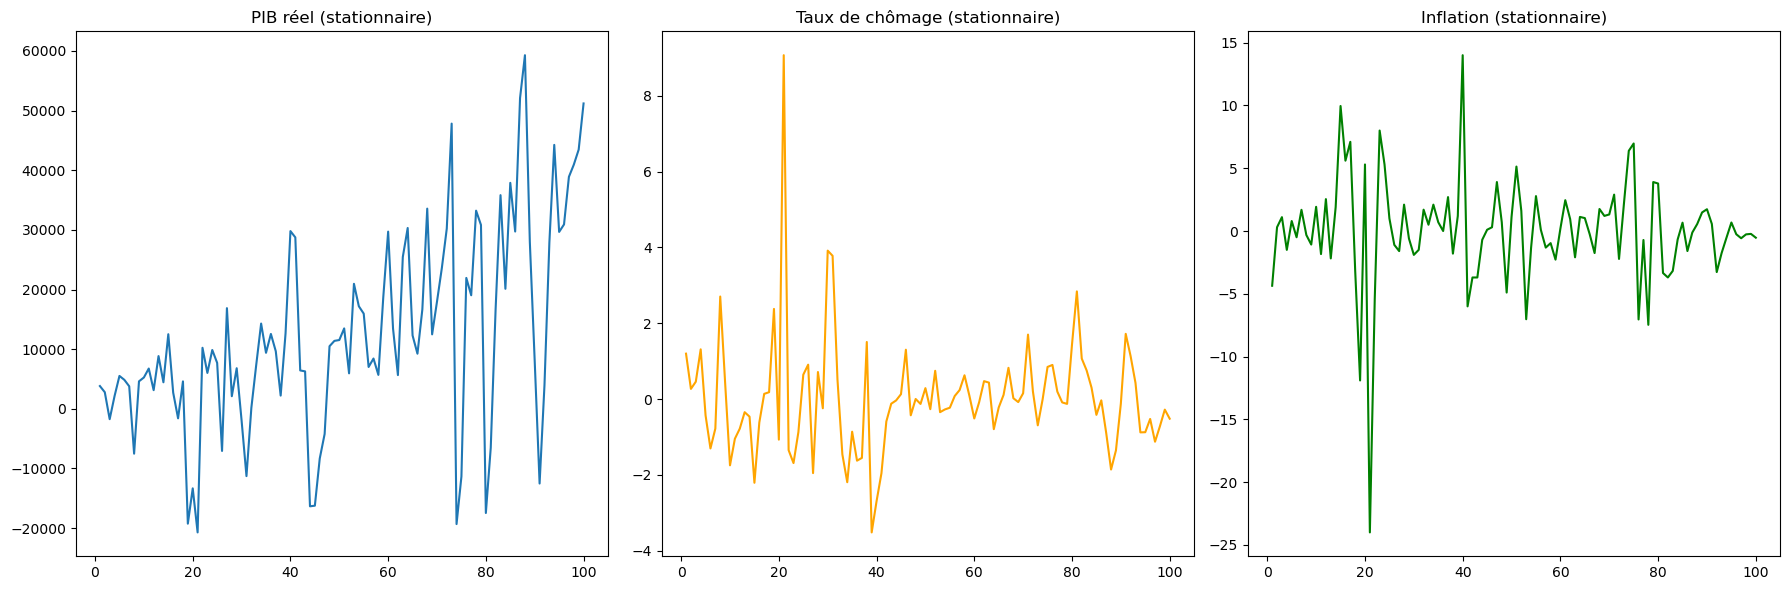

In [40]:
# Trace des séries temporelles stationnaires
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tracé de la série temporelle du PIB réel
axes[0].plot(df_diff["realGDP"])
axes[0].set_title("PIB réel (stationnaire)")

# Tracé de la série temporelle du taux de chômage
axes[1].plot(df_diff["unemployment"], color="orange")
axes[1].set_title("Taux de chômage (stationnaire)")

# Tracé de la série temporelle de l'inflation
axes[2].plot(df_diff["inflation"], color="green")
axes[2].set_title("Inflation (stationnaire)")

plt.tight_layout()
plt.show()

#### <span style="color:green"> Q32. Explain the difference between ACF and PACF. </span>

L'**Autocorrélation** (**ACF**) mesure la corrélation entre une série temporelle et ses propres décalages, aidant à identifier la présence de cycles répétitifs ou de saisonnalité. Cependant, **ACF** ne distingue pas si cette corrélation est directe ou si elle est influencée par d'autres décalages intermédiaires.

À l'inverse, l'**Autocorrélation Partielle** (**PACF**) évalue la corrélation entre la série et ses décalages après avoir exclu les effets des décalages intermédiaires, offrant ainsi une vision plus précise des relations directes.

Alors que l'**ACF** est cruciale pour identifier le degré approprié d'un modèle MA (Moyenne Mobile), la **PACF** est essentielle pour déterminer l'ordre d'un modèle AR (AutoRégressif), facilitant la construction de modèles de séries temporelles plus précis et significatifs.

#### <span style="color:green"> Q33. Plot and comment on the ACF and PACF of all variables.</span> FAIRE COMMENTAIRE

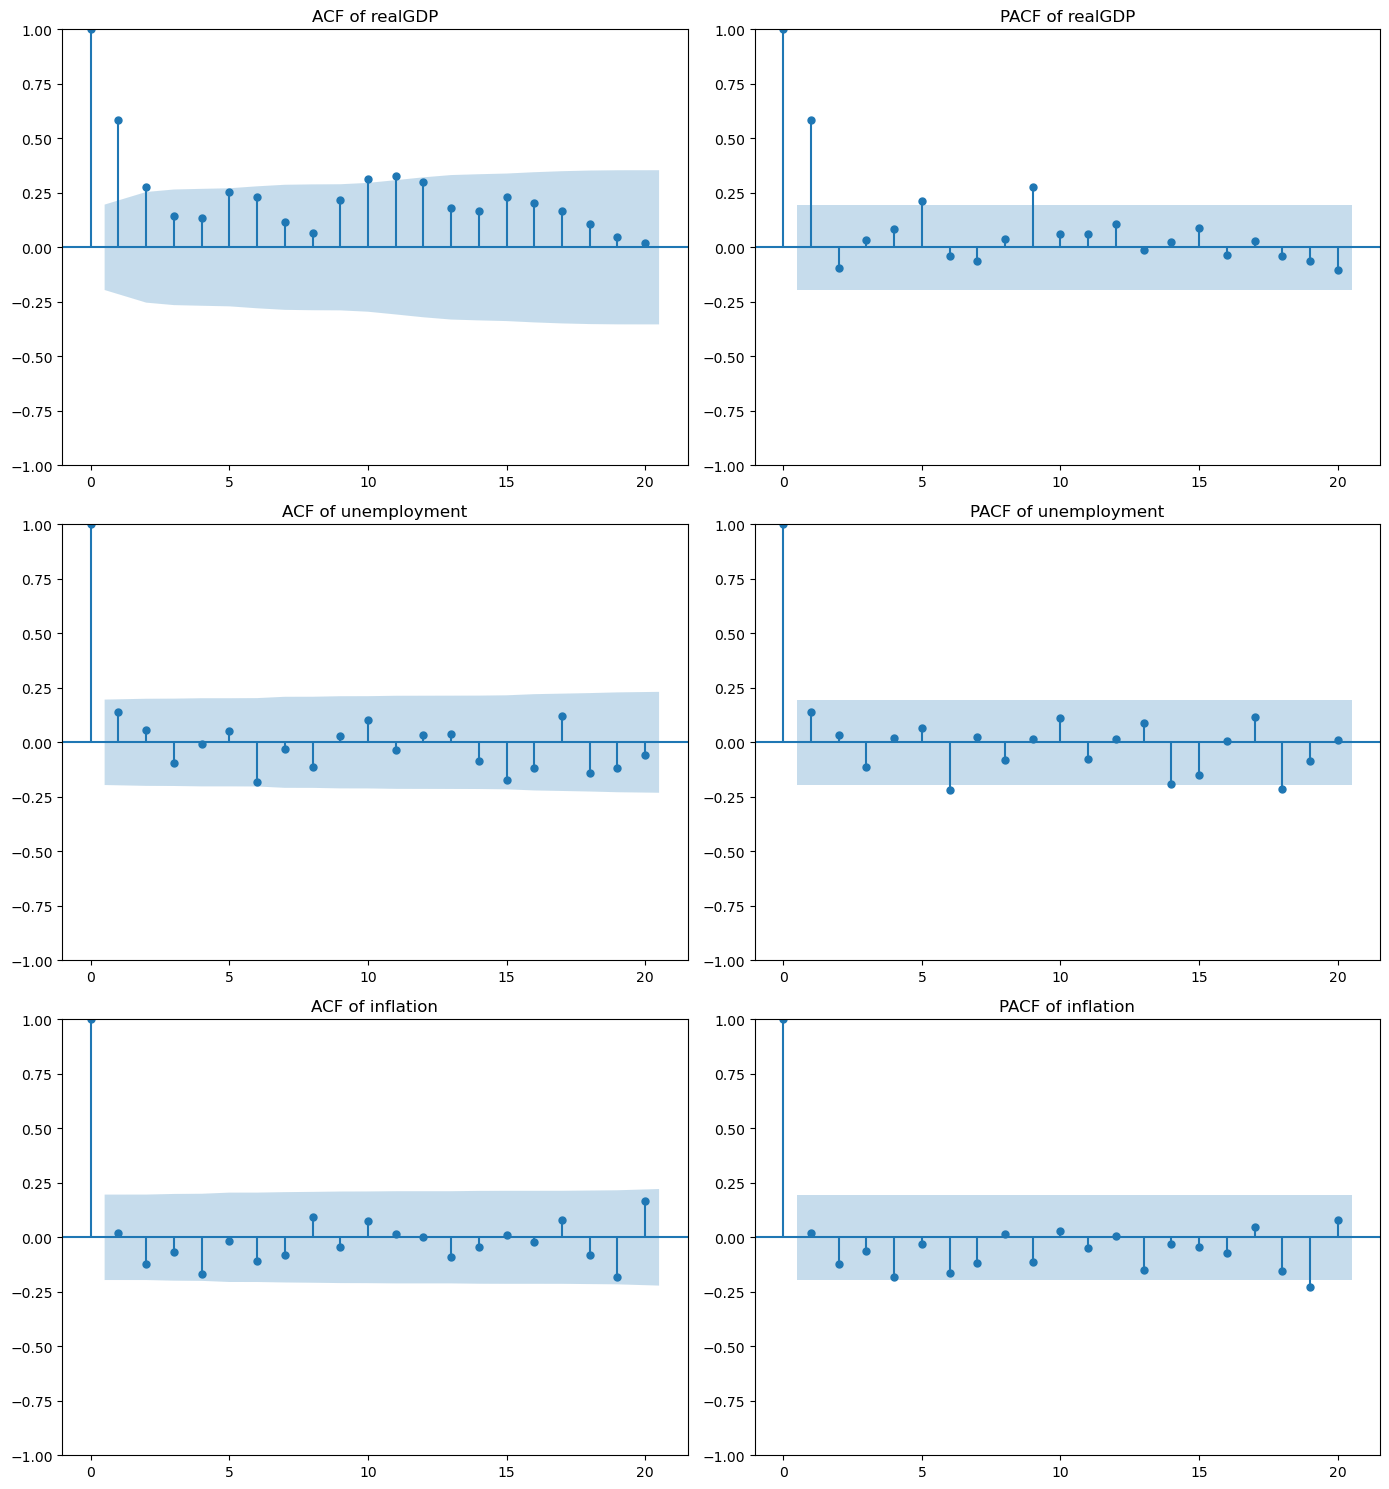

In [41]:
# Dataset prepared earlier
variables = ['realGDP', 'unemployment', 'inflation']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))

for i, variable in enumerate(variables):
    # ACF plots
    plot_acf(df_diff[variable], ax=axes[i, 0], title=f'ACF of {variable}')
    
    # PACF plots
    plot_pacf(df_diff[variable], ax=axes[i, 1], title=f'PACF of {variable}')

plt.tight_layout()
plt.show()

Pour l'**ACF** du **RealGDP**, on observe une décroissance lente indiquant une possible corrélation positive entre les valeurs passées et futures du **RealGDP**. Cela suggère un processus avec une forte persistance temporelle. En revanche, la **PACF** montre une coupure nette après le premier décalage, ce qui implique qu'un modèle AR(1) pourrait être approprié pour le **RealGDP**.

Concernant le **Unemployment**, l'**ACF** révèle aussi une décroissance lente mais avec des autocorrélations qui deviennent négatives, indiquant un modèle potentiellement plus complexe. La **PACF**, par contre, suggère un déclin rapide après les premiers décalages, ce qui laisse penser à un processus AR de faible ordre.

Pour **Inflation**, l'**ACF** montre une forte corrélation initiale qui diminue rapidement, ce qui peut suggérer un choc initial ayant un effet qui se dissipe rapidement. La **PACF** coupe après le premier décalage, ce qui indique également qu'un modèle AR(1) pourrait convenir.

#### <span style="color:green"> Q34. Explain the principle of parsimony and its relationship with Ockham’s razor using the theory of information criterion.</span>

Le principe de parcimonie, étroitement lié au rasoir d'Ockham, stipule qu'en présence de plusieurs hypothèses explicatives, **la plus simple doit être privilégiée, car elle a tendance à être la plus probable**.  
  
En économétrie, ce principe est opérationnalisé à travers les critères d'information tels que l'AIC et le BIC, qui équilibrent la complexité du modèle (le nombre de paramètres) et l'ajustement aux données.  
  
Un modèle plus parcimonieux a moins de paramètres tout en conservant un bon ajustement, réduisant ainsi le risque de surajustement (overfitting) et améliorant la capacité de généralisation du modèle. Ces critères imposent une pénalité pour les modèles plus complexes, favorisant ainsi la simplicité sans sacrifier la qualité de l'explication.

#### <span style="color:green">Q35. Explain the problem of auto-correlation of the errors.</span>

L'autocorrélation des erreurs se manifeste lorsque les résidus d'un modèle de régression sont corrélés les uns avec les autres. Cela signifie que les erreurs d'une période sont influencées par celles des périodes précédentes, ce qui contrevient à l'hypothèse d'indépendance des erreurs.

Ce phénomène pose problème dans l'estimation par les Ordinary Least Squares (OLS). Bien que les coefficients de régression estimés restent valables, ils ne sont plus les plus efficaces. De plus, Mean Squared Error (MSE) pourrait ne pas refléter correctement la vraie variance des erreurs, et l'écart-type des coefficients de régression pourrait ne pas être fiable pour estimer leur dispersion.

En présence d'autocorrélation, les méthodes statistiques habituelles et les intervalles de confiance perdent en fiabilité.

#### <span style="color:green"> Q36. Using only stationary variables, run a regression of GDP on constant, unemployment and inflation and test the hypothesis of no-autocorrelation of errors.</span> FAIRE COMMENTAIRE

In [42]:
# Assurer que les données sont de type numérique approprié
gdp_stationnaire = df_diff['realGDP'].astype(float)
unemployment_stationnaire = df_diff['unemployment'].astype(float)
inflation_stationnaire = df_diff['inflation'].astype(float)

# Définir la variable dépendante
y1 = gdp_stationnaire.values

# Création de la matrice des prédicteurs et ajout d'une constante pour l'intercept
const1 = np.ones(len(y1))
X = np.column_stack((const1, unemployment_stationnaire, inflation_stationnaire))

# Effectuer la régression linéaire
regression = sm.OLS(y1, X).fit()

# Calculer et analyser les résidus pour l'autocorrélation
residus = regression.resid
residus_retardes = residus[:-1]
y2 = residus[1:]
const2 = np.ones(len(y2))
X_residus = np.column_stack((const2, residus_retardes))
regression_residus = sm.OLS(y2, X_residus).fit()

# Tester l'hypothèse de non-autocorrélation des erreurs
seuil_significativite = 0.05
p_valeur = regression_residus.pvalues[1]

# Interprétation du test d'autocorrélation basé sur la p-value
if p_valeur < seuil_significativite:
    print(f"Rejet de H0 - Il y a autocorrélation dans les résidus, p-value: {p_valeur}")
else:
    print(f"On ne peut pas rejeter H0 - Il n'y a pas d'autocorrélation dans les résidus, p-value: {p_valeur}")

Rejet de H0 - Il y a autocorrélation dans les résidus, p-value: 1.8834347632719184e-10


In [43]:
dw = durbin_watson(residus)

print("Durbin-Watson statistic:", dw)

if dw < 2:
    print("Il y a une autocorrélation positive dans les résidus")
elif dw > 2:
    print("Il y a une autocorrélation négative dans les résidus")
else:
    print("Il n'y a pas d'autocorrélation dans les résidus")

Durbin-Watson statistic: 0.8053000430343398
Il y a une autocorrélation positive dans les résidus


#### <span style="color:green">Q37. Regardless of your answer to question 36, correct auto-correlation with GLS. Comment on your results.</span> FAIRE COMMENTAIRE

In [44]:
# Estimation du modèle AR(1) sur les résidus pour obtenir rho
model_residus_ar1 = sm.OLS(residus[1:], X_residus).fit()
rho = model_residus_ar1.params[1]

# Création de la matrice de corrélation des erreurs assumant une structure AR(1)
toeplitz_range = np.arange(len(y1))
sigma = rho ** toeplitz(toeplitz_range)

# Application de GLS avec la matrice de corrélation sigma
gls_model = GLS(y1, X, sigma=sigma)
gls_results = gls_model.fit()

# Affichage des résultats
print(gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            GLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     16.45
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           7.07e-07
Time:                        15:43:44   Log-Likelihood:                -1078.5
No. Observations:                 100   AIC:                             2163.
Df Residuals:                      97   BIC:                             2171.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.286e+04   2936.673      4.380      0.0

$\underline{Commentaire}$ : Les résultats de la régression **GLS** indiquent que le **Unemployment** (x1) et **Inflation** (x2) ont une relation significativement négative avec le **RealGDP** (y), comme le montrent les p-valeurs quasi nulles. Cela signifie que, toutes choses égales par ailleurs, une augmentation de **Unemployment** ou de **Inflation** est associée à une diminution de **RealGDP**. Le coefficient R-squared de 0.377 suggère que le modèle explique environ 37.7% de la variabilité de **RealGDP**. La statistique Durbin-Watson proche de 1.392 pourrait encore indiquer une autocorrélation positive des erreurs, bien que le problème soit moins prononcé qu'avant l'application de **GLS**. Cela suggère que le modèle peut encore être amélioré, peut-être en intégrant d'autres variables ou en utilisant une spécification différente pour la corrélation des erreurs.

#### <span style="color:green">Q38. For all variables, construct their lag 1 and lag 2 variables.</span>

In [45]:
# Création des variables avec un décalage de 1 et 2 pour chaque variable dans le DataFrame original 'df'
df_lag1 = df.shift(1).rename(columns=lambda x: f"{x}_lag1")
df_lag2 = df.shift(2).rename(columns=lambda x: f"{x}_lag2")

# Affichage des premières lignes pour vérification
df_lag1.head(), df_lag2.head()

(    realGDP_lag1 unemployment_lag1 inflation_lag1
 0           None              None           None
 1  181160.264436          3.679865       4.058273
 2  184974.529384          4.877351           -0.3
 3  187756.550527          5.145694              0
 4   186015.76815          5.603507        1.10331,
     realGDP_lag2 unemployment_lag2 inflation_lag2
 0           None              None           None
 1           None              None           None
 2  181160.264436          3.679865       4.058273
 3  184974.529384          4.877351           -0.3
 4  187756.550527          5.145694              0)

#### <span style="color:green">Q39. Run a regression of GDP on constant, lag 1 unemployment, lag 2 unemployment, lag 1 inflation, lag 2 inflation. What is the number of observations and why?</span> FAIRE COMMENTAIRE

In [46]:
# Fusion des DataFrames de décalage avec le DataFrame original pour aligner les données temporelles
df_merged = df.join(df_lag1[['unemployment_lag1', 'inflation_lag1']]).join(df_lag2[['unemployment_lag2', 'inflation_lag2']])

# Suppression des lignes contenant des None résultant des opérations de décalage
df_merged.dropna(inplace=True)

# Sélection des variables explicatives et de la variable réponse
X = df_merged[['unemployment_lag1', 'unemployment_lag2', 'inflation_lag1', 'inflation_lag2']].astype(float)
y = df_merged['realGDP'].astype(float)

# Ajout d'une constante pour l'intercept
const = np.ones(len(y))
X = np.column_stack((const, X))

# Réalisation de la régression linéaire
model = sm.OLS(y, X).fit()

# Le nombre d'observations utilisées dans la régression est égal au nombre de lignes dans df_merged après suppression des NaN
num_observations = df_merged.shape[0]

# Retourne le nombre d'observations et un résumé du modèle
print(f"Nombre d'observations : {num_observations}")
print(model.summary())

Nombre d'observations : 99
                            OLS Regression Results                            
Dep. Variable:                realGDP   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     5.302
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           0.000679
Time:                        15:43:44   Log-Likelihood:                -1393.3
No. Observations:                  99   AIC:                             2797.
Df Residuals:                      94   BIC:                             2810.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.279e+05   7

#### Q40. State and test the no-Granger causality hypothesis of unemployment on GDP at the 1% level.

In [47]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger causality test
granger_test = grangercausalitytests(df[['realGDP', 'unemployment']], maxlag=2)

# Extract the p-value from the test results
F, p_value, _, _ = granger_test[2][0]['ssr_ftest']

print(f"F: {F}\np-value: {p_value}\n")

if p_value < 0.1:
    print("Rejet de H0 - l'unemployment Granger cause le PIB réel\n")
else:
    print("On ne peut pas rejeter H0 - l'unemployment ne Granger cause pas le PIB réel\n")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8018  , p=0.0974  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=2.8884  , p=0.0892  , df=1
likelihood ratio test: chi2=2.8475  , p=0.0915  , df=1
parameter F test:         F=2.8018  , p=0.0974  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6092  , p=0.0789  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=5.4960  , p=0.0641  , df=2
likelihood ratio test: chi2=5.3489  , p=0.0689  , df=2
parameter F test:         F=2.6092  , p=0.0789  , df_denom=94, df_num=2
F: 2.609207646257232
p-value: 0.07891719959027316

Rejet de H0 - l'unemployment Granger cause le PIB réel



#### <span style="color:green">Q41. Divide the sample in two groups: 1900-1960 and 1961-2000. Test the stability of coefficients between the two periods.</span>

In [48]:
from scipy.stats import f

# Longueur du DataFrame
n = len(df)

# Séparation des données en deux groupes selon les années
groupe1 = df[0:51]
groupe2 = df[51:n]

# Calcul du modèle combiné pour tout le DataFrame
y_combine = df['realGDP'].astype(float)
X_combine = df[['unemployment', 'inflation']].astype(float)
X_combine = sm.add_constant(X_combine)
model_combine = sm.OLS(y_combine, X_combine).fit()
SSR_combine = model_combine.ssr

# Régression pour la première période (1900-1960)
y1 = groupe1['realGDP'].astype(float)
X1 = groupe1[['unemployment', 'inflation']].astype(float)
const1 = np.ones(len(y1))
X1 = np.column_stack((const1, X1))
model1 = sm.OLS(y1, X1).fit()
SSR1 = model1.ssr

# Régression pour la deuxième période (1961-2000)
y2 = groupe2['realGDP'].astype(float)
X2 = groupe2[['unemployment', 'inflation']].astype(float)
const2 = np.ones(len(y2))
X2 = np.column_stack((const2, X2))
model2 = sm.OLS(y2, X2).fit()
SSR2 = model2.ssr

# Nombre de paramètres estimés (incluant la constante)
k = X_combine.shape[1]

# Nombre d'observations dans chaque groupe
n1 = groupe1.shape[0]
n2 = groupe2.shape[0]

# Calcul de la statistique F
numerateur = (SSR_combine - (SSR1 + SSR2)) / k
denominateur = (SSR1 + SSR2) / (n1 + n2 - 2*k)
F = numerateur / denominateur
valeur_critique = f.ppf(0.95, k, n1 + n2 - 2*k)
p_valeur = 1 - f.cdf(F, k, n1 + n2 - 2*k)

# Affichage des résultats du test de Chow
print(f"Chow test F-statistic: {F}, p-value: {p_valeur}, valeur critique: {valeur_critique}")

# Seuil de signification pour un test bilatéral au niveau de 5%
alpha = 0.05

# Test de l'hypothèse H0 contre H1 au niveau de 5%
if p_valeur < alpha:
    print("On rejette l'hypothèse nulle H0 au niveau de 5%. Les deux groupes ont des coefficients différents.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0 au niveau de 5%. Les deux groupes ont des coefficients similaires.")

Chow test F-statistic: 140.46716783543897, p-value: 1.1102230246251565e-16, valeur critique: 2.7004090629698054
On rejette l'hypothèse nulle H0 au niveau de 5%. Les deux groupes ont des coefficients différents.


#### <span style="color:orange">Q42. Test the structural breakpoint using a trim ratio of 30% at the 1% level.</span>

In [49]:
# Calcul du modèle global pour obtenir SSR
model_global = sm.OLS(y, X).fit()
SSR = model_global.ssr  # Erreur de somme des carrés pour le modèle global

# Initialisation des variables pour la boucle
n = len(df)
F_max = 0
breakpoint = 0

# Boucle pour identifier le point de rupture, maintenant avec SSR défini
for i in range(int(0.15 * n), int(0.85 * n)):  # Taux de trim de 30% pour le test de rupture
    # Modèle pour la première sous-période
    y1 = y[:i]
    X1 = X[:i]
    model1 = sm.OLS(y1, X1).fit()
    SSR1 = model1.ssr
    
    # Modèle pour la deuxième sous-période
    y2 = y[i:]
    X2 = X[i:]
    model2 = sm.OLS(y2, X2).fit()
    SSR2 = model2.ssr
    
    # Calcul de la F-statistic pour le point de rupture potentiel
    F = ((SSR - SSR1 - SSR2) / (SSR1 + SSR2)) * ((n - X.shape[1]) / 2)
    
    if F > F_max:
        F_max = F
        breakpoint = i

print(f"Point de rupture optimal: {breakpoint}, avec une F-statistic de: {F_max}")

Point de rupture optimal: 61, avec une F-statistic de: 316.5631295493285
